<a href="https://colab.research.google.com/github/anderm18/CurlingVAR/blob/main/CurlingHouseClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curling Neural Network (Convolutional)

Since we're working with annotated images with 3 channels (RGB) it makes the most sense to use a 2D convolutional network. This will reduce the number of parameters and greatly increase performance, we can also keep our image coloring though I imagine this may not stick, since colored images require us to train on a 3D tensor (3 color channels) while a grayscale allows us to efficiently perform in 1 channel only, so we can operate in 2 dimensions instead of 3, which will yield quicker model results, though sometimes less accurate.

All models will be trained on an NVIDIA Tesla V100 Tensor Core GPU with 32 GB of VRAM

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=77d170e6c2d194e320abbfada2640fa4692396c1f7908bd87cf7de9ddbabc48d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


Here's my first attempt at a Convolutional Neural Network:

In [2]:
import os
import torch
import PIL
import pandas as pd
from torchviz import make_dot
from google.colab import drive
from IPython.display import Image
from matplotlib import pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Pulling in the Dataset (importing on Colab is a massive pain):

In [8]:
class CurlingDataset(Dataset):

  _train = None
  _test = None
  _validate = None

  def __init__(self, csv_loc, img_dir, set_type="train", transform=None, target_transform=None):
    self.data = pd.read_csv(csv_loc)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform


    if type(CurlingDataset._train) == type(None):
      print("Performing a split")
      CurlingDataset._train, CurlingDataset._test, CurlingDataset._validate = self.__split()

    self.data = CurlingDataset._train if set_type == "train" else (CurlingDataset._test if set_type == "test" else CurlingDataset._validate)

  def __len__(self):
    return len(self.data)

  def __split(self):

    train, test = train_test_split(self.data, train_size=.70, stratify=self.data['empty'])
    test, validate = train_test_split(test, train_size=.50, stratify=test['empty'])

    return train, test, validate

  def __getitem__(self, index):

    img_path = os.path.join(self.img_dir, self.data.iloc[index, 2])
    image = PIL.Image.open(img_path).convert('RGB')
    label = torch.tensor(int(self.data.iloc[index, 3]))

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="train",
    transform=transform
)

test_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="test",
    transform=transform
)

validate_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="validate",
    transform=transform
)

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)
validate_dataloader = DataLoader(validate_data, batch_size=32)

## The Model

This is a simple convulational neural network. I'm starting off with the following convulational stack:


```
    self.conv_stack = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, 3, stride=1, padding=1),  <- Input Layer
        torch.nn.ReLU(),
        torch.nn.Conv2d(16, 32, 3, stride=1, padding=1), <- Hidden Layer
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 32, 3, stride=1, padding=1), <- Hidden Layer
        torch.nn.ReLU()
    )
```

and a second Fully Connected stack:

```
    self.fc_stack = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(32 * 512 * 512, 128), <- Input Layer (technically hidden)
        torch.nn.ReLU(),
        torch.nn.Linear(128, 128), <- Hidden Layer
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64), <- Hidden Layer
        torch.nn.ReLU(),
        torch.nn.Linear(64, 2) <- Output Layer
    )
```


The idea here is that the convolutional network can make better inferences on an image than a classic Fully Connected Neural Net, but it is not very good at making classifications, hence why we connect the output of the Convolutional Layer to the Fully Connected Neural Network (FCNN). The goal is that the complex inferences made by the CNN can allow us to train a good enough classifier on the FCNN to interpret the results to 0 or 1. Technically speaking, this is a pipeline and not just one network...

In [5]:
class CurlingClassifierCNN(torch.nn.Module):
  def __init__(self):
    super(CurlingClassifierCNN, self).__init__()
    self.conv_stack = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, 3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 64, 3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(64, 64, 3, stride=1, padding=1),
        torch.nn.ReLU()
    )

    self.fc_stack = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(64 * 128 * 128, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2),
    )

  def forward(self, x):
    logits = self.fc_stack(self.conv_stack(x))
    return logits

Switch to the V100 GPU to speed things up:

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Get some model info about how many parameters we have:

In [20]:
model = CurlingClassifierCNN().to(device)

print(model)
print("\nOur Model's Layers (as Tensors):")
for param in model.parameters():
  print(param.size())

CurlingClassifierCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1048576, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

Our Model's Layers (as Tensors):
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 1048576])
torch.Size([128])
torch.Size([2, 128])
torch.Size([2])


In [22]:
test_input = torch.rand(32, 3, 512, 512).to(device)
logits = model.forward(test_input)
print(logits.size())

torch.Size([32, 2])


Now that we know the model is set up correctly, let's plot a diagram. The initial model is very hefty and maybe a bit overkill, so I may come back and add some Max Pooling layers to the CNN so that we are reading a reduced amount of data is this seems to be too much to train. The code cell below will help visualize the Network to help debug if needed so that we can see all Neurons and biases. I also outputted 2 output Neurons, as with a softmax this will give a better probability distribution over the two classes (Empty house vs Full House)

NOTE: This cell will save an image to your filesystem, this is so my Colab runtime will properly render the whole image to just the cell since torchviz won't take that into account when displaying.

UPDATE: I ran out of memory after the first batch, soooo I added a few Max Pool layers to reduce the size of the feature map....

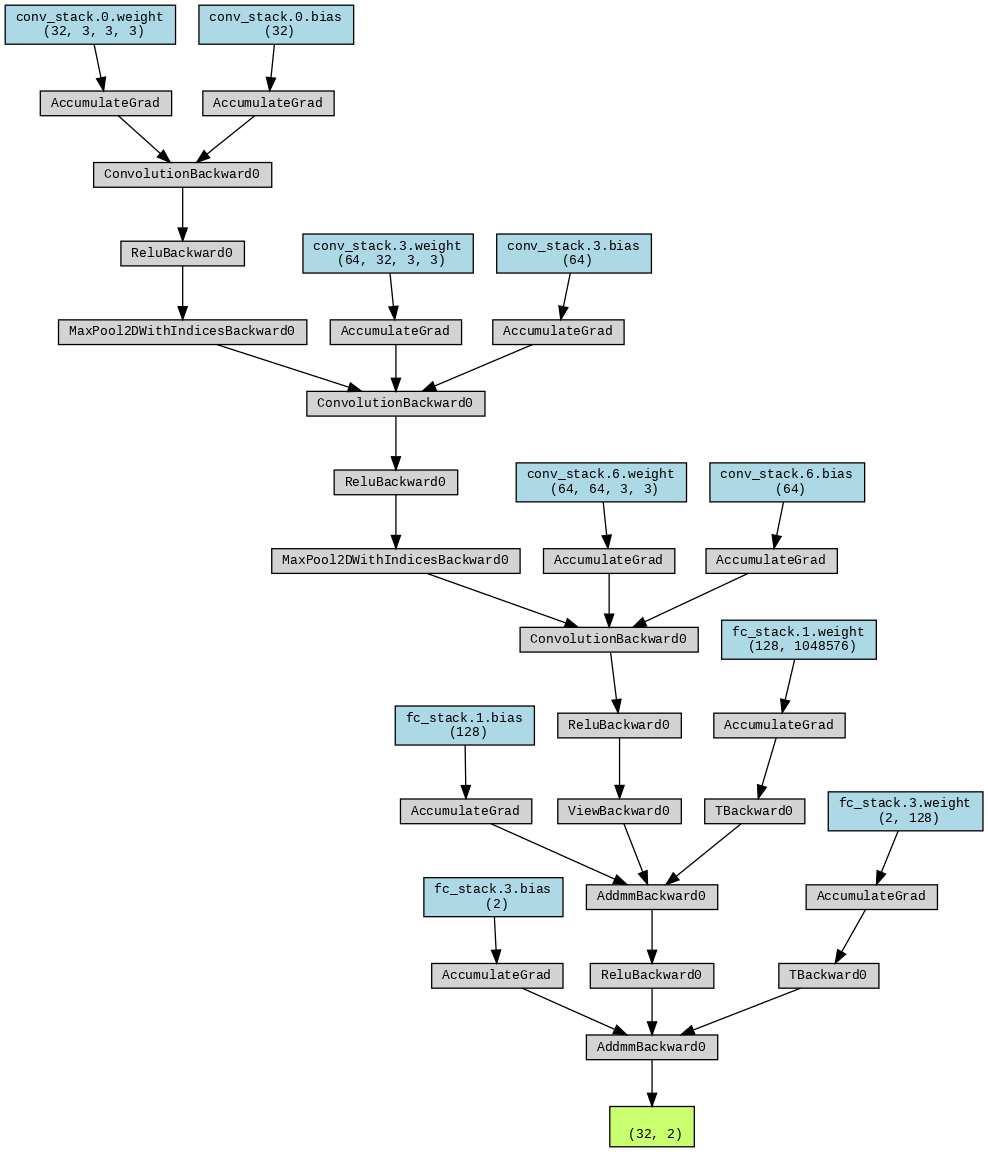

In [23]:
dot = make_dot(logits, params=dict(list(model.named_parameters()) + [('x', test_input)]))
dot.render('network_visualization', format='png')
Image('network_visualization.png')

#### Loss Function: Cross Entropy Loss

We'll be starting with a Cross Entropy Loss (CEL) function as for our purposes a standard Loss function should do the trick, and CEL tends to produce a faster rate of convergence and have a steeper gradient than other loss functions. Basically, it's good for our purposes and fast

#### Optimizer: Stochastic Gradient Descent

I'm hoping Stochastic Gradient Descent is enough for this, though I might switch to Adam. The main difference is that SGD has a static learning rate while Adam dynamically adjusts its learning rate during training. Overall, I'm open to the switch, but let's start with a static learning rate.

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

Now, we just need a train and test function to get to training. Like most test functions, this is going to just be pretty much by the book because if it ain't broke don't fix it:

In [12]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 2 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Now for the test function, most of it is also by the book with one key difference. In order to convert the resulting 2 class Tensor, we can convert to 1 classification and compare to the ground truths by using:

$x → Predictions\;by\;Model\;(Tensors\;of\;Size\;1x2)$\
$y → Ground\;Truths\;(Scalar\;Values,\;1/0)$\
$n → Batch\;Size$

$Correct\;Predictions = \sum_{i=1}^{n} 1_{softmax(x(i, 0), x(i, 1)) = y(i)}$

This might seem complicated, but in reality, it's quite simple. Basically, we're taking the $softmax(x(i, 0), x(i, 1))$, which is the softmax of our output Tensor values. Then, once we have them in either a 1 or 0, we compare them to the actual classification. Taking the sum of each time this happens will yield the number of correct predictions our model made.

In [11]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now, we can begin training. Something to note on performance here is that the first Epoch is going to take significantly longer than others. The reason for this is a little complicated, but in short since we are training on a GPU we need to load images in VRAM and not just Normal RAM. The process is as follows:

```
Load into RAM -> Transfer to GPU VRAM -> Load on VRAM -> Process
```

You can see how this can take a minute. What's good is PyTorch and CUDA handle a lot of this for us already, so we really only need to tell it when to load into VRAM using `.to()` and CUDA+PyTorch handles the rest. But, we do have to wait for it still. However, it keeps everything in our session loaded in VRAM, so once we load a frame tensor into VRAM, it stays and as such can be quickly accessed again, hence why epoch 1 takes significantly longer than the rest.

In [ ]:
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss, optimizer)
  test(test_dataloader, model, loss)

Epoch 1
-------------------------------
loss: 0.698358  [    0/ 1309]
loss: 1.412617  [   64/ 1309]
loss: 1.585696  [  128/ 1309]
loss: 0.580961  [  192/ 1309]
loss: 0.884265  [  256/ 1309]
loss: 0.675992  [  320/ 1309]
loss: 0.614848  [  384/ 1309]
loss: 0.581160  [  448/ 1309]
loss: 0.587577  [  512/ 1309]
loss: 0.665204  [  576/ 1309]
loss: 0.478803  [  640/ 1309]
loss: 0.422887  [  704/ 1309]
loss: 0.582337  [  768/ 1309]
loss: 0.440620  [  832/ 1309]
loss: 0.561242  [  896/ 1309]
loss: 0.375793  [  960/ 1309]
loss: 0.379668  [ 1024/ 1309]
loss: 0.376262  [ 1088/ 1309]
loss: 0.409936  [ 1152/ 1309]
loss: 0.259965  [ 1216/ 1309]
loss: 0.161123  [ 1160/ 1309]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.222669 

Epoch 2
-------------------------------
loss: 0.302086  [    0/ 1309]
loss: 0.219818  [   64/ 1309]
loss: 0.113809  [  128/ 1309]
loss: 0.182694  [  192/ 1309]
loss: 0.138781  [  256/ 1309]
loss: 0.194808  [  320/ 1309]
loss: 0.045053  [  384/ 1309]
loss: 0.014118  [  448/ 1309

First Run\
total failure. I suspect the learning rate to be low as the model is learning (loss slowly decreasing) but not at a rate that yields any viable results. This was done with a learning rate of 1e-4

Second Run\
great success! I changed the FCNN classifier to be a bit simpler, as it seemed like the issue was not the learning rate but the complexity of the classification network. I also normalized the images using the Normalize transform, since I knew it would work I just used the ImageNet normalization values (again, if it ain't broke, don't fix it). We yieled a 95% Accuracy weight on classifying empty or full houses, which is pretty good! I'd like to tweak it a bit to get more into the 97-98% territory, but we can come back to this later.

Now, let's run against the validation set:


In [ ]:
test(validate_dataloader, model, loss)

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.235110 



Those are some incredible results! Something to note is that I don't want to train for too many epochs out of fear of overfitting, since this dataset is small. If I get more people/resources, I can hopefully get a bigger dataset and train for much much longer. I want to print out some images as well as some data on the comparisons to help better tweak this model to make it more efficient in the future. For this purpose, and since the model has already seen my 3 datasets, I'm ok with just using the validation set for this without the risk of data snooping:

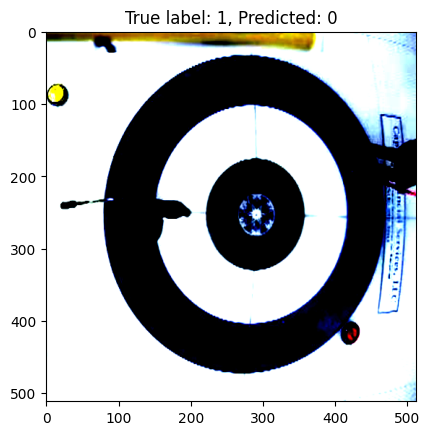

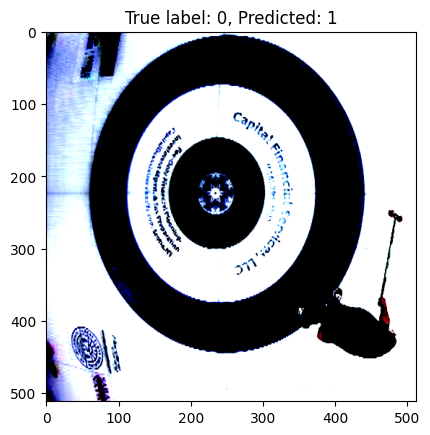

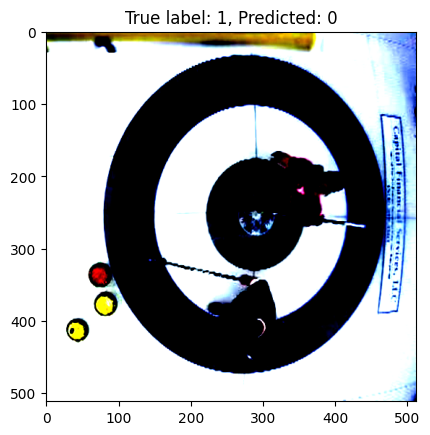

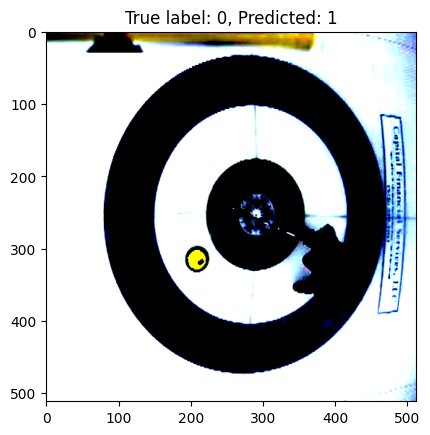

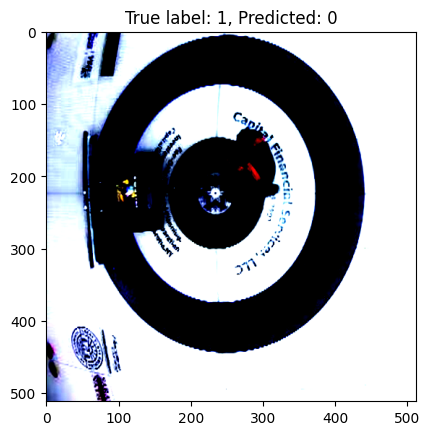

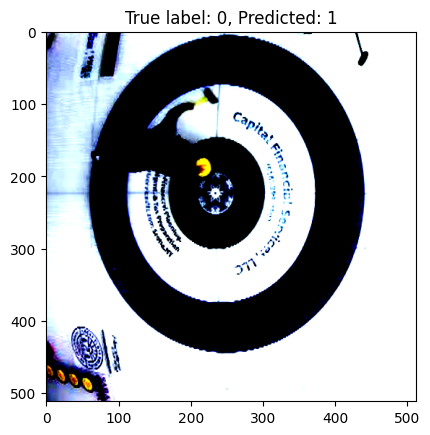

Correct: 263.0/281
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.235110 



In [ ]:
feature_batch, label_batch = next(iter(validate_dataloader))
size = len(validate_dataloader.dataset)
num_batches = len(validate_dataloader)
model.eval()
misclassified_image = []
misclassified_label = []
misclassified_pred = []

# This is to collect for a confusion Matrix
preds = []
targets =[]


test_loss, correct = 0, 0
with torch.no_grad():
  for X, y in validate_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    test_loss += loss(pred, y).item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    preds.append((pred.argmax(1)).type(torch.float).cpu())
    targets.append(y.type(torch.float).cpu())

    misclassified_idx = (pred.argmax(1) == y).logical_not().nonzero(as_tuple=True)[0]
    if len(misclassified_idx) > 0:
        misclassified_image.append(X[misclassified_idx[0]])
        misclassified_label.append(y[misclassified_idx[0]].item())
        misclassified_pred.append(pred[misclassified_idx[0]].argmax().item())

for misclassified_image, misclassified_label, misclassified_pred in zip(misclassified_image, misclassified_label, misclassified_pred):
    misclassified_image = misclassified_image.cpu().permute(1, 2, 0)  # Change from CxHxW to HxWxC
    misclassified_image = torch.clamp(misclassified_image, 0, 1)  # Ensure image values are within [0, 1]
    plt.imshow(misclassified_image)
    plt.title(f"True label: {misclassified_label}, Predicted: {misclassified_pred}")
    plt.show()

test_loss /= num_batches
print(f"Correct: {correct}/{size}")
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

So a few things here, one: I find it hilarious that the model thought that somebody's head was a red stone. With more training on houses with people in them, we could probably solve this. Two: It seems that the model may have found an image I misclassified! I will need to review my annotations, though I also wonder if maybe there is a stone near the man that with normalization is not appearing in the post processed image above. Now, we can form a confusion matrix on the model:

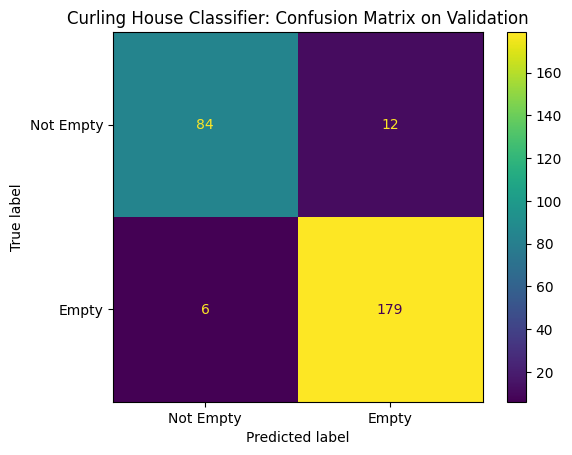

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np

targets = torch.concatenate(targets).ravel()
preds = torch.concatenate(preds).ravel()
cm = confusion_matrix(targets, preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Not Empty', 'Empty'])

disp.plot()
plt.title("Curling House Classifier: Confusion Matrix on Validation")
plt.show()

In [ ]:
f1 = f1_score(targets, preds, average='binary')
print("F1 Score on Validation:", f1)

F1 Score on Validation: 0.9521276595744682


In [ ]:
torch.save(model, '/content/drive/My Drive/CurlingClassifier.pth')
torch.save(model.state_dict(), 'CurlingClassifierParams.pth')

# Results

## Test:
### Accuracy: %95.0 on Test
### Avg. Loss: 0.412264
$\;$
## Validation:
### Accuracy: %97.2 on Validation
### Avg. Loss: 0.255877
### F1 Score: 0.9785



# Curling Classifier: Mid Size Dataset
Basically, the same as above but using the new midsize dataset created in CurlingDataRetrieval:

In [9]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_mid1_out/meta.csv",
    "/content/drive/My Drive/achilles2022_mid1_out/",
    set_type="train",
    transform=transform
)

test_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_mid1_out/meta.csv",
    "/content/drive/My Drive/achilles2022_mid1_out/",
    set_type="test",
    transform=transform
)

validate_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_mid1_out/meta.csv",
    "/content/drive/My Drive/achilles2022_mid1_out/",
    set_type="validate",
    transform=transform
)

Performing a split


In [10]:
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)
validate_dataloader = DataLoader(validate_data, batch_size=32)

In [ ]:
model_midsize = CurlingClassifierCNN().to(device)

In [ ]:
mid_loss = torch.nn.CrossEntropyLoss()
mid_optimizer = torch.optim.Adam(model_midsize.parameters(), lr=.0001)

In [ ]:
epochs = 15
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model_midsize, mid_loss, mid_optimizer)
  test(test_dataloader, model_midsize, mid_loss)

Epoch 1
-------------------------------
loss: 0.697345  [    0/ 1885]
loss: 0.674379  [   64/ 1885]
loss: 1.558252  [  128/ 1885]
loss: 1.112822  [  192/ 1885]
loss: 0.684409  [  256/ 1885]
loss: 0.736608  [  320/ 1885]
loss: 0.714449  [  384/ 1885]
loss: 0.694773  [  448/ 1885]
loss: 0.680321  [  512/ 1885]
loss: 0.711456  [  576/ 1885]
loss: 0.727119  [  640/ 1885]
loss: 0.700385  [  704/ 1885]
loss: 0.677078  [  768/ 1885]
loss: 0.731975  [  832/ 1885]
loss: 0.718373  [  896/ 1885]
loss: 0.692069  [  960/ 1885]
loss: 0.704242  [ 1024/ 1885]
loss: 0.693762  [ 1088/ 1885]
loss: 0.695539  [ 1152/ 1885]
loss: 0.690116  [ 1216/ 1885]
loss: 0.686845  [ 1280/ 1885]
loss: 0.675832  [ 1344/ 1885]
loss: 0.663318  [ 1408/ 1885]
loss: 0.690362  [ 1472/ 1885]
loss: 0.690908  [ 1536/ 1885]
loss: 0.758910  [ 1600/ 1885]
loss: 0.658504  [ 1664/ 1885]
loss: 0.615955  [ 1728/ 1885]
loss: 0.659067  [ 1792/ 1885]
loss: 0.649982  [ 1682/ 1885]
Test Error: 
 Accuracy: 68.6%, Avg loss: 0.620307 

Epoch 2


In [ ]:
test(validate_dataloader, model_midsize, mid_loss)

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.071389 



In [ ]:
torch.save(model_midsize, '/content/drive/My Drive/CurlingMidClassifier.pth')
torch.save(model_midsize.state_dict(), 'CurlingMidClassifierParams.pth')

In [6]:
model_mid = torch.load('/content/drive/My Drive/CurlingMidClassifier.pth')

In [17]:
mid_loss = torch.nn.CrossEntropyLoss()
test(validate_dataloader, model_mid, mid_loss)

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014716 



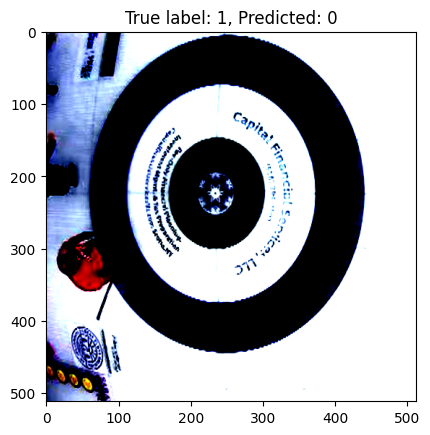

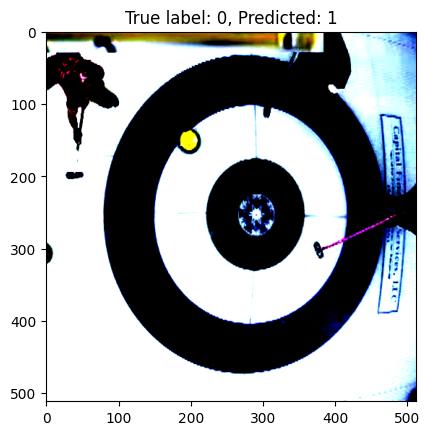

Correct: 403.0/405
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014716 



In [18]:
feature_batch, label_batch = next(iter(validate_dataloader))
size = len(validate_dataloader.dataset)
num_batches = len(validate_dataloader)
model_mid.eval()
misclassified_image = []
misclassified_label = []
misclassified_pred = []

# This is to collect for a confusion Matrix
preds = []
targets =[]


test_loss, correct = 0, 0
with torch.no_grad():
  for X, y in validate_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model_mid(X)
    test_loss += mid_loss(pred, y).item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    preds.append((pred.argmax(1)).type(torch.float).cpu())
    targets.append(y.type(torch.float).cpu())

    misclassified_idx = (pred.argmax(1) == y).logical_not().nonzero(as_tuple=True)[0]
    if len(misclassified_idx) > 0:
        misclassified_image.append(X[misclassified_idx[0]])
        misclassified_label.append(y[misclassified_idx[0]].item())
        misclassified_pred.append(pred[misclassified_idx[0]].argmax().item())

for misclassified_image, misclassified_label, misclassified_pred in zip(misclassified_image, misclassified_label, misclassified_pred):
    misclassified_image = misclassified_image.cpu().permute(1, 2, 0)  # Change from CxHxW to HxWxC
    misclassified_image = torch.clamp(misclassified_image, 0, 1)  # Ensure image values are within [0, 1]
    plt.imshow(misclassified_image)
    plt.title(f"True label: {misclassified_label}, Predicted: {misclassified_pred}")
    plt.show()

test_loss /= num_batches
print(f"Correct: {correct}/{size}")
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Results

## Test:
### Accuracy: %98.3 on Test
### Avg. Loss: 0.103417
$\;$
## Validation:
### Accuracy: %98 on Validation
### Avg. Loss: 0.071389
